This is the Solution for the question 1 of the Exercise 2 from the [exercise series 2](https://github.com/righetti/optlearningcontrol/tree/master/Spring2020/series2) for the course Optimal and Learning Control (ME-GY 7973).

# Stabilizing the Cart-Pole system

In this exercise, we will use LQR to stabilize a cart-pole system and then adapt the LQR controller to get the robot to move along a specified path.

<img src="cart_pole.png" alt="drawing" width="400"/>

The difficulty of the cart-pole system is that we can only move the cart back and forth (using $u$) to move both the cart and the pendulum. Therefore, it is not trivial to find a good controller to get the pendulum to stay balanced on top of the cart while moving the cart around. We will see how we can use our optimal control approach to do such things.

In [1]:
# setup matplotlib for nice display in Jupyter
%matplotlib notebook

# a few libraries we will need
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp

# note in order to use the animation package to display movies you will need to install ffmpeg
# on Mac with homebrew: brew install ffmpeg
# on ubuntu: apt-get install ffmpeg
# on windows: https://ffmpeg.org/download.html#build-windows
import matplotlib.animation as animation

import IPython

np.set_printoptions(precision=5,linewidth=120,suppress=True)

## The cart-pole model

The dynamics of the cart-pole can be written as
\begin{align} 
\dot{x} &= v\\
\dot{\theta} &= \omega\\
\dot{v} &= \frac{u + m_p \sin\theta (l \omega^2 + g \cos\theta)}{m_c  + m_p \sin^2 \theta} \\
 \dot{\omega} &= \frac{-u\cos\theta - m_p l \omega^2\cos\theta \sin\theta - (m_c + m_p)g\sin\theta}{l(m_c  + m_p \sin^2 \theta)}\end{align}
 
There are four states: the position $x$ and linear velocity $v$ of the cart, the angle of the pendulum $\theta$ and its angular velocity $\omega$. There is one control input $u$ which is the force applied on the cart. We will write $z = \begin{bmatrix} x & \theta & v & \omega \end{bmatrix}^T$ the state vector.

We know that the point where the pendulum is vertical is an unstable fixed point of the system. We would like to stabilize the fixed point $\bar{z} = \begin{bmatrix} \bar{x} & \bar{\theta} & \bar{v} & \bar{\omega} \end{bmatrix}^T = \begin{bmatrix} 0 & \pi & 0 & 0 \end{bmatrix}^T$.

Like most robotic systems, it is not linear. It is also underactuated, i.e. we have only one control input to control two degrees of freedom.

We will first linearize the system around $\bar{z}$ (with $\bar{u}=0$) and then compute a LQR control law to stabilize it. The control law will be approximately optimal for the nonlinear system but should be a good enough approximation when sufficiently close to the fixed point.

## Linearizing the dynamics
We linearize $\dot{z} = f(z,u) \simeq f(\bar{z},\bar{u}) + \frac{\partial f}{\partial z}_{|z=\bar{z}, u=\bar{u}} (z - \bar{z}) + \frac{\partial f}{\partial u}_{|z=\bar{z}, u=\bar{u}}(u - \bar{u})$.

We have $f(\bar{z},\bar{u}) = 0$. 

Next, we compute the partial derivatives of the dynamics with respect to all state and control variables.

For the first two equations, this is straightforward:
\begin{equation}\frac{\partial}{\partial x} v = 0,\ \frac{\partial}{\partial \theta} v = 0, \ \frac{\partial}{\partial v} v = 1,\ \frac{\partial}{\partial \omega} v = 0\end{equation}
\begin{equation}\frac{\partial}{\partial x} \omega = 0,\ \frac{\partial}{\partial \theta} \omega = 0, \ \frac{\partial}{\partial v} \omega = 0,\ \frac{\partial}{\partial \omega} \omega = 1\end{equation}

For the third equation:
$$\frac{\partial}{\partial x} \left(\frac{u + m_p \sin\theta (l \omega^2 + g \cos\theta)}{m_c  + m_p \sin^2 \theta} \right) = 0$$
$$\frac{\partial}{\partial \theta} \left(\frac{u + m_p \sin\theta (l \omega^2 + g \cos\theta)}{m_c  + m_p \sin^2 \theta}\right) = \frac{(m_p\cos\theta(l \omega^2 + g \cos\theta) - m_pg\sin^2\theta)(m_c  + m_p \sin^2 \theta) - (u + m_p \sin\theta (l \omega^2 + g \cos\theta)) (2m_p \sin\theta\cos\theta) }{(m_c  + m_p \sin^2 \theta)^2}$$
which evaluated at $z=\bar{z}, u=\bar{u}$ gives $$\frac{m_p g}{m_c}$$
Now for the linear velocity
$$\frac{\partial}{\partial v} \left(\frac{u + m_p \sin\theta (l \omega^2 + g \cos\theta)}{m_c  + m_p \sin^2 \theta}\right) = 0$$
and for the angular velocity
$$\frac{\partial}{\partial \omega} \left(\frac{u + m_p \sin\theta (l \omega^2 + g \cos\theta)}{m_c  + m_p \sin^2 \theta}\right) = \frac{2m_p \sin\theta l \omega}{m_c  + m_p \sin^2 \theta}$$
which evaluated at $z=\bar{z}, u=\bar{u}$ gives 0

Finally we have
$$\frac{\partial}{\partial x} \left(\frac{-u\cos\theta - m_p l \omega^2\cos\theta \sin\theta - (m_c + m_p)g\sin\theta}{l(m_c  + m_p \sin^2 \theta)}\right) = 0$$
$$\frac{\partial}{\partial \theta} \left(\frac{-u\cos\theta - m_p l \omega^2\cos\theta \sin\theta - (m_c + m_p)g\sin\theta}{l(m_c  + m_p \sin^2 \theta)}\right) = \frac{(u\sin\theta - m_p l \omega^2 (\cos^2\theta - \sin^2 \theta) - (m_c + m_p)g\cos\theta) (l(m_c  + m_p \sin^2 \theta)) - (-u\cos\theta - m_p l \omega^2\cos\theta \sin\theta - (m_c + m_p)g\sin\theta)(2l m_p \sin\theta\cos\theta)}{(l(m_c  + m_p \sin^2 \theta))^2}$$
which evaluated at $z=\bar{z}, u=\bar{u}$ gives $$\frac{(m_p + m_c) g}{lm_c}$$
For the linear velocity
$$\frac{\partial}{\partial v} \left(\frac{-u\cos\theta - m_p l \omega^2\cos\theta \sin\theta - (m_c + m_p)g\sin\theta}{l(m_c  + m_p \sin^2 \theta)}\right) = 0$$
and finally
$$\frac{\partial}{\partial \omega} \left(\frac{-u\cos\theta - m_p l \omega^2\cos\theta \sin\theta - (m_c + m_p)g\sin\theta}{l(m_c  + m_p \sin^2 \theta)}\right) = \frac{- 2m_p l \omega\cos\theta \sin\theta}{l(m_c  + m_p \sin^2 \theta)}$$
which evaluated at $z=\bar{z}, u=\bar{u}$ gives 0.

We now compute the partial derivatives with respect to the control command. We have
$$\frac{\partial}{\partial u} v = 0$$
$$\frac{\partial}{\partial u} \omega = 0$$
$$\frac{\partial}{\partial u} \left(\frac{u + m_p \sin\theta (l \omega^2 + g \cos\theta)}{m_c  + m_p \sin^2 \theta}\right) = \frac{1}{m_c  + m_p \sin^2 \theta}$$
which evaluated at $z=\bar{z}, u=\bar{u}$ gives $$\frac{1}{m_c}$$
and the last one
$$\frac{\partial}{\partial u} \left(\frac{-u\cos\theta - m_p l \omega^2\cos\theta \sin\theta - (m_c + m_p)g\sin\theta}{l(m_c  + m_p \sin^2 \theta)}\right) = \frac{-\cos\theta}{l(m_c  + m_p \sin^2 \theta)}$$
which evaluated at $z=\bar{z}, u=\bar{u}$ gives $$\frac{1}{lm_c}$$

We can gather all these terms and get the linearized dynamics
$$\dot{z} = \begin{bmatrix} 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & \frac{m_p g}{m_c} & 0 & 0 \\ 0 & \frac{(m_p + m_c) g}{lm_c} & 0 & 0 \end{bmatrix} (z - \bar{z}) + \begin{bmatrix} 0 \\ 0 \\ \frac{1}{m_c} \\ \frac{1}{lm_c} \end{bmatrix} (u-\bar{u})$$

Finally, we change coordinates to center around the linearized point, we set $\tilde{z} = z - \bar{z}$ and $\tilde{u} = u-\bar{u}$ and get the following dynamics
$$\dot{\tilde{z}} = \begin{bmatrix} 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & \frac{m_p g}{m_c} & 0 & 0 \\ 0 & \frac{(m_p + m_c) g}{lm_c} & 0 & 0 \end{bmatrix} \tilde{z} + \begin{bmatrix} 0 \\ 0 \\ \frac{1}{m_c} \\ \frac{1}{lm_c} \end{bmatrix} \tilde{u}$$


In [2]:
class CartPole:
    """
    This class describes a cart pole model and provides some helper functions
    """
    
    def __init__(self):
        """
        constructor of the class, takes as input desired discretization number
        for x (angle), v (angular velocity) and u (control) and the maximum control
        """
        #store discretization information
        self.road_length = 3.
        
        #gravity constant
        self.g=9.81

        #integration step
        self.dt = 0.01
        
        #we define lengths and masses
        self.l = 1.0
        self.mc = 5.0
        self.mp = 1.0
            
    def next_state(self,z,u):
        """
        Inputs:
        z: state of the cart pole syste as a numpy array (x,theta,v,omega)
        u: control as a scalar number
        
        Output:
        the new state of the pendulum as a numpy array
        """
        x = z[0]
        th = z[1]
        v = z[2]
        om = z[3]
        x_next = (x + self.dt * v)
        th_next = (th + self.dt * om)
        v_next = v + self.dt*((u + self.mp*np.sin(th)*(self.l*om**2 + self.g * np.cos(th)))/(self.mc+self.mp*np.sin(th)**2))
        w_next = om + self.dt*((-u*np.cos(th)-self.mp*self.l*(om**2)*np.cos(th)*np.sin(th)-(self.mc+self.mp)*self.g*np.sin(th))/(self.mc+self.mp*np.sin(th)**2))
        z = np.array([x_next,th_next,v_next,w_next])
        return z
    
    def simulate(self, z0, controller, horizon_length):
        """
        This function simulates the pendulum of horizon_length steps from initial state x0
        
        Inputs:
        z0: the initial conditions of the pendulum as a numpy array (x,theta,v,omega)
        controller: a function that takes a state z as argument and index i of the time step and returns a control u
        horizon_length: the horizon length
        
        Output:
        z[4xtime_horizon+1] and u[1,time_horizon] containing the time evolution of states and control
        """
        z=np.empty([4, horizon_length+1])
        z[:,0] = z0
        u=np.empty([1,horizon_length])
        for i in range(horizon_length):
            u[:,i] = controller(z[:,i],i)
            z[:,i+1] = self.next_state(z[:,i], u[:,i])
        return z, u        

In [3]:
def animate_cart_pole(x, dt):
    """
    This function makes an animation showing the behavior of the cart-pole
    takes as input the result of a simulation (with dt=0.01s)
    """
    
    min_dt = 0.1
    if(dt < min_dt):
        steps = int(min_dt/dt)
        use_dt = int(min_dt * 1000)
    else:
        steps = 1
        use_dt = int(dt * 1000)
    
    #what we need to plot
    plotx = x[:,::steps]
    
    fig = mp.figure.Figure(figsize=[8.5,2.4])
    mp.backends.backend_agg.FigureCanvasAgg(fig)
    ax = fig.add_subplot(111, autoscale_on=False, xlim=[-4.25,4.25], ylim=[-1.,1.4])
    ax.grid()
    
    list_of_lines = []
    
    #create the cart pole
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    
    cart_length = 0.5
    cart_height = 0.25
    
    def animate(i):
        for l in list_of_lines: #reset all lines
            l.set_data([],[])
        
        x_back = plotx[0,i] - cart_length
        x_front = plotx[0,i] + cart_length
        y_up = cart_height
        y_down = 0.
        x_pend = plotx[0,i] + np.sin(plotx[1,i])
        y_pend = cart_height - np.cos(plotx[1,i])
        
        list_of_lines[0].set_data([x_back, x_front], [y_down, y_down])
        list_of_lines[1].set_data([x_front, x_front], [y_down, y_up])
        list_of_lines[2].set_data([x_back, x_front], [y_up, y_up])
        list_of_lines[3].set_data([x_back, x_back], [y_down, y_up])
        list_of_lines[4].set_data([plotx[0,i], x_pend], [cart_height, y_pend])
        
        return list_of_lines
    
    def init():
        return animate(0)


    ani = animation.FuncAnimation(fig, animate, np.arange(0, len(plotx[0,:])),
        interval=use_dt, blit=True, init_func=init)
    plt.close(fig)
    plt.close(ani._fig)
    IPython.display.display_html(IPython.core.display.HTML(ani.to_html5_video()))

# Question 1:
We would like to use the linearized equation to compute an optimal controller that stabilizes the system around the resting position.

1. Write a cost function that will help stabilize the resting position $\bar{z}$ (be precise with the variables you use).
2. Compute the infinite horizon gains to stabilize the cart pole system
3. Write a function that can stabilize the system and test the behavior of the robot using $z_0 = [0.5, \pi + 0.3, 0., 0.]^T$. Plot the time evolution of the control input and the states of the system.
4. What is the behavior of the system when starting with $z_0 = [0.5, 0.3, 0., 0.]^T$? Explain the behavior.

#### 1) 
Since the cost fucntion is to stabilize the system to a given resting position $\bar{z}$, we make a cost fuction that tries to make the error zero, while error is $z-\bar{z}$. Since it is one single position the system has to maintain, the cost can be consisder a simple Linear Quadratic Regulator with a feedabck as shown here.

$$ \min_{\mathbf{u}_n} \sum_{n=0}^{N} \left[\mathbf({z}_{n}-\bar{z})^T \mathbf{Q}_n ({z}_{n}-\bar{z}) + {u}_n^T \mathbf{R}_n {u}_n\right]$$

#### 2)
Infinite horizon problem means that $N = \infty$, which makes the cost function:

$$ \min_{\mathbf{u}_n} \sum_{n=0}^{\infty} \left[\mathbf({z}_{n}-\bar{z})^T \mathbf{Q}_n ({z}_{n}-\bar{z}) + {u}_n^T \mathbf{R}_n {u}_n\right]$$

Unlike for a finite horizon problem, there cannot be N different <b>K</b> (optimal control gain) for an inifite horizon porblem, so we iterate the Ricatti equation until P stops to change, and then find the corresponding controol gain for the system.

<p> Following are the Ricatti equations used: 
    
\begin{equation}
    P_{n} = Q + A^{T} P_{n-1} A - A^{T} P_{n-1} B (B^{T} P_{n-1} B + R)^{-1} B^{T} P_{n-1} A 
\end{equation}
    
In this context, the subscript $n$ is to signify the number of iteration and it is meaningless to associate this $n$ to the cost function for an infinite horizon problem.
Once the value of P converges we use that P to find the control gain K, using the following equation:

\begin{equation}
K = - (B^{T} P B + R)^{-1} B^{T} P A 
\end{equation}

The function to solve these equation is defined in the cell below &darr;

In [4]:
def solve_ricatti_equations_inf(A,B,Q,R):
    
    P = Q # A random initial value is considered, it should be a positive definite matrix of size 4x4 for this system
    it = 0 # keep count of the number of iterations
    
    while True:
        Pnew = Q + A.transpose().dot(P).dot(A) - A.transpose().dot(P).dot(B).dot(np.linalg.inv(B.transpose().dot(P).dot(B) + R).dot(B.transpose()).dot(P).dot(A))
        it += 1
        if(np.allclose(P,Pnew,0.00001)):
            break
        P = Pnew
        
    K = -1.0 * np.linalg.inv(B.transpose().dot(P).dot(B) + R).dot(B.transpose()).dot(P).dot(A)
    
    print("The P value converges at iteration ", it)
    
    # since we went backward we return reverted lists
    return P, K

The control input uses a only a feedback, since it is trying keep the system in a constant state rather than try to make any changes overtime (like following a trajectory): 

\begin{equation}
    u_{n} = K (z_{n}-\bar{z})
\end{equation}

There is no feedforward gain added, since the system is to remain in a one position.

A function performing the same is defined below &darr;

In [5]:
def LQ_error(z,i):
    # z_d SHOULD BE DEFINED AS A GLOBAL VARIABLE for this function to work. Format => z_d = np.array([0, np.pi, 0, 0])
    return K.dot(z-z_d)

In [6]:
# we call in the created cart pole
cart = CartPole()

# definig the dynamics of the system
A = np.array([[1, 0, cart.dt, 0],[0, 1, 0, cart.dt],[0, cart.dt*cart.mp*cart.g/cart.mc, 1, 0], [0, cart.dt*(cart.mp+cart.mc)*cart.g/(cart.l*cart.mc), 0, 1]])
B = np.array([[0],[0],[cart.dt/cart.mc],[cart.dt/(cart.l*cart.mc)]])

#define a desired resting position
z_d = np.array([0., np.pi, 0., 0.])

# definig the cost terms Q & R
Q = np.array([[10, 0, 0, 0],[0, 10, 0, 0],[0, 0, 10, 0],[0, 0, 0, 10]])*10
R = np.eye(1)*1

# Call in a function to solve the Ricatti Equations, so to get P and K
P, K = solve_ricatti_equations_inf(A,B,Q,R)
print("The Infinite Horizon Gain is")
print(K)

The P value converges at iteration  505
The Infinite Horizon Gain is
[[   9.52631 -220.93711   20.18649  -67.98051]]


#### 3)
For this part of the question, the cart is simulated with an initial pendulum position only 0.3 rad away form the initial position. 

$$z_{0} = \begin{bmatrix}
            0.5\\ \pi+0.3 \\ 0 \\ 0
           \end{bmatrix} $$

In [7]:
#defining the initial condition and the other desired conditions to simulate the cart with the control
z0 = np.array([0.5,np.pi+0.3,0.,0.])

# A Horizon length is given inorder to simulate the system rather than for the working of the controller
horizon_length = 1000

# Simulating the cart with the control
z,u = cart.simulate(z0, LQ_error, horizon_length)

<IPython.core.display.Javascript object>


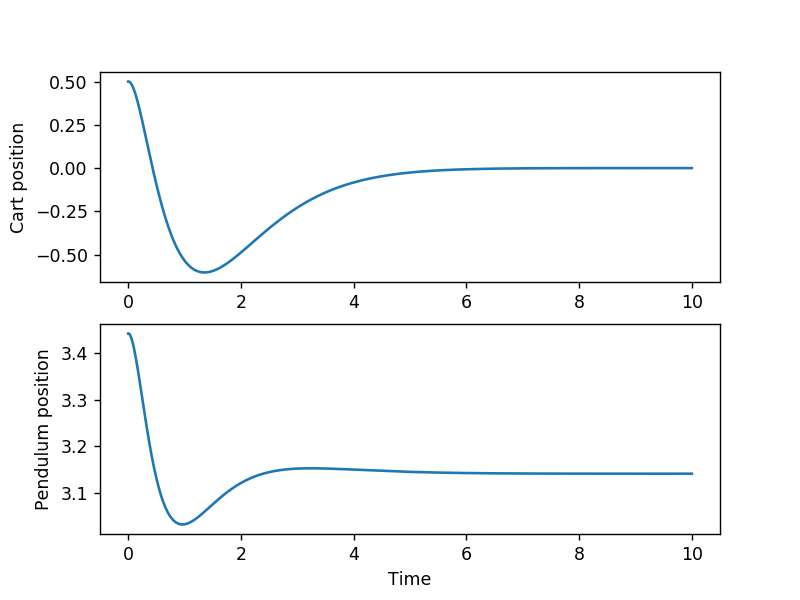

Text(0.5, 0, 'Time')

In [8]:
# Plotting the Cart position and the Pendulum Position in a graph

t = np.linspace(0,cart.dt*(horizon_length),horizon_length+1)
plt.figure()
plt.subplot(2,1,1)
plt.plot(t,z[0,:])
plt.ylabel('Cart position')
plt.subplot(2,1,2)
plt.plot(t,z[1,:])
plt.ylabel('Pendulum position')
plt.xlabel('Time')

As seen above &uarr;, the graph shows that the system stabilizes both the position of the cart and the position of the pendulum to the desired resting position. The animation performing the same is shown below &darr;

In [9]:
animate_cart_pole(z, cart.dt)

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAA1yG1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU4IHIyOTg0IDM3NTlmY2IgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE5IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NyBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAA+3ZYiE
AD///vdonwKbWkN6gOSVxSXbT4H/q2dwfI/pAwAAAwAAAwAAAwAAdaFhgCmhz+EeJXEB8N6fIJ7J
rhIV+NN9XHf+yK6HeTLxVohwsVcDo5RFQnt96ggNjzTuW/beQ9Ceg3f9LFZ5ZPoaVjdmAKgN7/Gc
Kr0gtL00uCkVv1C53J99XsNJS/gNuHwTwL/869qoBhYjy5uu8WFFmrWtWDaRdcnj8LIQheD+ZCpx
gkynhBs7lzV0l+dmgpnYqcFe9agMwPZxfZ6TsAXXBMimcd4t/zryQN1fDIYSk9uOyNmB2dbE0nan
iGuaDdg1QjhVvUgGjEZ5vRM7EsCj1LZlOyN2eVBD9ggXgtoRXyLV35nG5BTBuVuxfI/uRIpSQuI1
aQOsOZM0jnlxJWF6Z8su0s+VaHZ38DWb7+nlX8NzBrLW7/+N1GSk3ln4HeXKC7DRwLQUi6WRR4CT
6rz0yv60q2FbnjO4O3hX6bbkHU2e+lFON+pT/LOF6124cCAOWJZPal907pEV1sQJXp0smV5/wUMg
v+uXXltT9cXuBmbs9zf/kWiCIMIQF8JGkOXUzJu5IeYJIGu64kxZg1oRAK6xpAVWTGHhiCoxWSx0
6A8YcoKFxuE0CgOr5YhJ9EZ4K9r7MIVlVokgKF0vav7Fvn3GD4BSLEGjx6OZcQDfMD7gaqfc2NyJ
6mICR/9wLSVMlMJS6KXGVQCQRt6aN+xL4dx8b+wguN92d/RlDQiWe2CwZQFrz81Vh88aQoneNEUt
dP3CTNMUXpYXJsGFqfQUbJ6NLR7huTqNbUqr3nsOCoGpHJz4yWe8fPbG1IUIXRkLDHQbBmz5cXHB
FBLEd9M+ilu80Dqj8FXKEUAVNzQkfrOvXUXC+wrm0I8dt1G9DVIk4KASDcJBwm/sM05a7WLU8Zms
wCDD96SYMGD79ctjuHE5MONVEJnEiWm8DrbrZCypXzc40DsXRlFGG2Gnp0gqD3PZh5P7iYwPF0PY
M5vH64XaB6GgAAX4HXGWU+RA3eklX7friM2Kiv/7gFmBSB7dSMZfL5vhDjQtxnAYvXxX6gYJMW+6
ZgYB/BYOkOTAYdnuGJpTPKY22Wm94B7fxpRHSabMQAUM64xEZByFuhYobOIwl96UV7v8Whp2jfFy
02//+MGu+tvmSpzi+u2QQjYlsPI/h757dRYBx0iidKthbFupK7dNUGMxJkhSevd+pvD8M3GyhsAx
s0TXCequJqjpxgm4L9LInVZyuV620RbHCOA58fFqZXdGY2bkBWo7akPemNrUncqV5j8Tqe9be6tg
oGZ5e/3VOHW3T8XcnAnKCQA0oBIgAATkR6PyE6ZtCDgOvccb1GwHT2XNk9DyJ1CsJUFsQjTKCOzC
lZHzfU/PkfhT7Kzfrcumk7pOuMAxs8V4YUxZT/sI7GbOaBYLjEMHXhxqgABdR4iIYwJvElElmPOE
5S6OJSTV+GJ1cJ5WI6hnHuvysve9pEfmEraDkvHsT9GXh8wTW/XtlX15Jrd1T2Tfn/9wRHhxsKmf
7Ai6bAHjA7TSkamQXD37zwrliHM4wqR/j6hZbuY1RE1g7DSmaIB7UlnN5NXVUOCZiguraEOWfEFX
lhWBjSjgcJINigV0R226Gs6Eh2RYEBGBjpNwHcFxNr82bR3Skktu5fQrbTeSUxhfbQp9e2MRVL/8
sZrkRj4kFcZX6p+GKIJHwHYcrraGcawIgqA7vy3exMgOG+CtS7bdvnNMs7LxqcWi6bu+wfK0TxW2
Vg5rhk1/cbFHPt+Tw/1AWq2hoFuvYaIHGQOgSSvbi28ne3/MpNtVKY3jE9kqSV6ZLvpLKP+Kd511
L66L64SUMqNwwKdMufUrZP50pye6VvbXP/Uzy3EEg3JxLj18y0XEy+yPpcmLWPiQ9khJ9U+DKOIg
3m3KSplraPh4Muf83T+TpDoW8S+WblClNmhxcLOuuADbibzDyppYGiZyLV+veIl4ZXsNvlkKfEc+
8DxqasdV7Nwem5H1BnyA10n12oqu5mmTWZ8dyA7wvuPqOZ1j9R9t5QP53Sru4AlReUS8n8oEoMTm
AHTqqH5tbauYH0iS0+s+WOcE5V0e1jLkXnlIFiyQd1XhC2R8ze7YOX1Z27AAgVslXAaAQTg8yBuy
CX3KOKNWl5KaekBMyn+NNt2mstcy6NDZV5nHHKSaY7SW3jL58CVaBK9SG3spESFKxqgBUYJEPMJ+
LGIMUxQnnkrtWU981UbClbS/TpXMk1HXPOtRZp97LiEbbv/IRCWu7Ofku6Ke+VZJ01fPlX99TZT5
gQRYN+WCa1aVX6MQdO8GM42KLPu1HNtWObodPbuD9GDUaI/l11KGtKnVVmzFWIyHL3ge96KQIq3w
0GaUxXABS9RDiA8IDAbfEEzgf979FgMIaZrf32kCmHx9MN/XU/h5qjCLvxP7d2hm6GgJzR6TCqmH
LY/x81iPjJ/CAdJgFsK2PF+yZqoNhQipAPI/WyrSmY4p1jDW28T/zL2y3q5jdwzKapXuygiJiPIs
cBKvpsisjqwVWfppxlVuOoHdbHpO0YpRAFHyTlkN5GxdU+VRJVlOuWmQzw7iKAmeYxKK/RyDxW12
R2+Co1p+9yYIltIWIFvToNBjzpTVzkWSeoCHUQsKqfUDkWFwylm3zr9PPrRvYpj6XztI2Pt8V9mM
qL8FQnG8NdJ1/8CCu3P2MAr/23PxY70AAAMA+e/TIMalACY7uIDfrYAA+/DNYPmuxWNEvuxDGd98
HeK6cPSPs2QPZyRI7/G3VqAK78n/9EeA9qcimB0ihY+BlmMRA/EsdrTRtJPh/YagJFAiPKi0mpiV
okG0xg4pMTrVzZEntKnzFwaKr0HDiubHYc7GQwDJFvY8NTo+Wor2HmesMgeN5Qv8HO9O68HcIo+Y
0rEHwYGRl9vYNqRQj9a+G

#### 4) 
We try and perform the same with a different initial condition, this time with th pendulum very far from the desired resting position.

$$z_{0} = \begin{bmatrix}
            0.5\\ 0.3 \\ 0 \\ 0
           \end{bmatrix} $$

Through trial, it was realized that this system needs different costs; <b>Q</b> & <b>R</b>.

In [10]:
# we call in the created cart pole
cart = CartPole()

# definig the dynamics of the system
A = np.array([[1, 0, cart.dt, 0],[0, 1, 0, cart.dt],[0, cart.dt*cart.mp*cart.g/cart.mc, 1, 0], [0, cart.dt*(cart.mp+cart.mc)*cart.g/(cart.l*cart.mc), 0, 1]])
B = np.array([[0],[0],[cart.dt/cart.mc],[cart.dt/(cart.l*cart.mc)]])

#define a desired resting position
z_d = np.array([0., np.pi, 0., 0.])

# definig the cost terms Q & R
Q = np.array([[0.8000,    0.8000,    0.8005,    0.8016],[0.8000,    0.8001,    0.8007,    0.8019],[0.8005,    0.8007,    0.8014,    0.8027],[0.8016,    0.8019,    0.8027,    0.8040]])*0.000001
R = np.eye(1)*1000

# Call in a function to solve the Ricatti Equations, so to get P and K
P, K = solve_ricatti_equations_inf(A,B,Q,R)
print("The Infinite Horizon Gain is")
print(K)

The P value converges at iteration  91229
The Infinite Horizon Gain is
[[   0.00003 -115.85498    0.01505  -33.76928]]


In [11]:
#defining the initial condition and the other desired conditions to simulate the cart with the control
z0 = np.array([0.5,0.3,0.,0.])

# A Horizon length is given inorder to simulate the system rather than for the working of the controller
horizon_length = 1000

# Simulating the cart with the control
z,u = cart.simulate(z0, LQ_error, horizon_length)

<IPython.core.display.Javascript object>


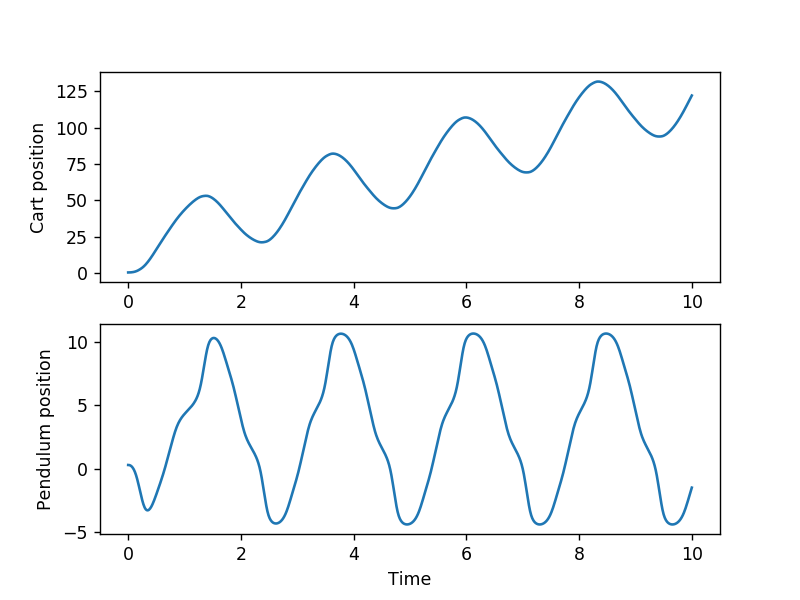

Text(0.5, 0, 'Time')

In [12]:
# Plotting the Cart position and the Pendulum Position in a graph

t = np.linspace(0,cart.dt*(horizon_length),horizon_length+1)
plt.figure()
plt.subplot(2,1,1)
plt.plot(t,z[0,:])
plt.ylabel('Cart position')
plt.subplot(2,1,2)
plt.plot(t,z[1,:])
plt.ylabel('Pendulum position')
plt.xlabel('Time')

In [13]:
animate_cart_pole(z, cart.dt)

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAAfj21kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU4IHIyOTg0IDM3NTlmY2IgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE5IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NyBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAA/EZYiE
ABD//veBvzLLXyK6yXH5530srM885DxyXYmuuNAAAAMAAAMAAAMABiMSN/6J4P4R4lcQE8kYWQT6
y3KCuinXVt83n9H0S0FxzClEFKxd1+TNS++zCta62/NP06dt9j0J6Dkf2rHaFv+dr20t1Bp3zX58
DBmkFpamrwUtoW26plf3qfo7kHaQyI08hEByMoaqItBilNRZ9xftAaNrfFzgbRx0zytlSZ7wyT/A
hWDCoOtQa0dEz95yhN3uVkH/sJoWqLvH6jo9pLsuTBPgi8kL8+yRBKPqVQ/YUDgwspb8Gnl6iUwZ
SurlWB0QXIgiBsb9xLD0CubzvixG8obluC6puxpOWyCYkAbatLU9jaC6EwsXEj+MlAWQBEJnFmon
oyTi8n0C0BKkW/r4xDr20Mgn+As9aPbE4158j/U2cEGxsD+LAx8n1ABol8bPKscdoc/NLOlg9pn4
16RMT+6SCUf+x7E0q2jztUa7lppa0uU7fP2cihnDlXP0SLhbPzcba+v6lTJont47ZpsCZxHf0yQC
KsNfufJ30ADdSnV2hwLCo9HvHLPbUaKXHDGoEHHo1WpVbro4AyhlKHS4R2POcQzDHQQpD01Egeg5
lEnIllRd2OJYfjP8tNQeyhkxZZ8vp9ng2KsnhBG2vCR+e8C6sinjAFN/BFpKmSmEo50v8xs0AE6N
/UE4OeRZBosW+0BvucH9m8bJ/lwr1tA7UQAUuwOto8aQoneNEU1oHnjFTQnvgNyjMNP0kpealaS5
m8cFk0UXO8jBucXBfOSpbLSxTfG82h1FTualEKTSftHmURQcNweaqaCK6IQJ7aDPKnIaIrGND/ly
e7C8cskfvJ+ONoDBweEoZr/wcIp95BBArj4BTJSzjfjhReDuvBRg+6EWdm9I6ACn7s8AAAMAWQ/4
L5IU7B/A1eFLvqdp5kqRtZtf/JdigJdemTBVG8a1vorjoq/vWz48+EuOKuxsrQY2//7gJV26qWWZ
XQUSB+z3+3x6Zfjk9nOyYOh1iOdZqwv+BAMTPHCLTHIn0c5rrGN4+67eCKUVfHnF8BlnBgAwf2bO
zuKos7BV2pQR0BKB7ezX7bksAVb8btOIAboVRnZa+kIntyiejIFNtu0if/PaW4uxBu8np++6gC4S
+lCku5duAa7zJcAAFRrOJlC+6wy4XG3A0F+/UkMTsEwKbV+3+FvC0TW50g3B6bOillAVJt3qhzGf
aNzb5342WjFWBqHXiKS6dQ6DJX827424ujDaTWILZcJPk2qt3V3ai/TOjJoV6+aGd2Jq3wuTiLb7
3YvNPx7zx1Wn06mR3IMchIfcdOO2o974E0vIHJZpVzRRVArojdMnuyokOyK/s0TGcU/IK1iv/Fmv
Hy7VueLR0lkjMN4BZdM+Qub76EM/YqCW//d97hGwN84wLiGbupLZ7vgqt7TaKEjfxQvsQOpDpk3i
X28jeWorVy0XtbDVdMIVqVpZo8mXbR7N8cpRbMZ1AYh234ZhZhb+sW7/NMAAJZNm45OWqKrh9z0M
tCD/qepNhhPI/IPuwQ5IfguODgFdGalMoDY0/SL3TDM1WDcGYjbqbR5xpIz55ohWo3OgE4aokH2X
PNRpLJNYs6/EMmIewJmZcuQTP9h2pf/fQcUjvOgq32KSXBzfzhqd/lkJzg6Msc9pB//VsFkcYgWn
lRiyzTx6AJwy7/E/S2+kigyzWnDY8P2zLOPx6Lu4FaHhImypKYw9HOiFZlThzMN/DJVQakJtoT+k
7LmqJGyD4TMQbak8Le4sSugmJi7buzRwmhTywpLh9EAP5F7QZAKTDM2/yhnjbuKhbYG59cYkmNR9
JDCsa9dc77hgFYVzDDhMuhvl95yejT5X8hywOjPSwEJPTRdildo6grJ82nFS7B2O8asGByqg8OhU
wgYAHf36dhhxIH3bpFX0iEJRoYWpwJCu40c9VhTS5N2kqJHBvq3Nar58q/vqbJtySemZVz78hkrs
HrNFGRrBhcUvNiW0c2y6oHrV9Oo7owajSHzdW0H4Sp1VZsxVCMhy0Z546opAirfDQZpTFyISXUQ4
gPB6G3vY46YkH65BS0GrKZ/M5ZKkEM3f+2tGNWu7aWK8bhBV+MCU5X1AOQsmfLL01cBffvTg2GTN
QlcCAFsKzIPKZfxC0h+FtOXf+tlWlMxxTrGEIMzF1uJfmJxNvJRc6HIv8X4oQSxXMKhVlbKL/0hD
lUsU6JjoZi74tmxrhFJ3c+1algwQ//WG6nayDqHwj1xEAfxg4EXfBxPFrzvueW/zo+fC/6Vxhrmt
x8s0ZdibqoX+yeRKDH3/umNXw/60wEp8hljB+TdddfEG5DUfPKNZ6Kkpov9fPmYWJcwrsSTSCPJW
OOneK6sbVbBpt2IvKcjad/3/ast05ozs2d/JUA8lxcoHYKWQ1aHcaRPxjpK6hHendMdEsCgAjr6J
ymfjgA6LNdDK6eU7dr74TraG7nBlz+3Aon+pFF4So0ZBNMJJIPyvdSXr2kTza7Mbi4HJDrl/v24k
mrPxCittABIDRZHl93hv461ZIVmD1KunMstYJrvrwTObKwGCMJeCzuxD7wSgW3LNTzwIpu/ATocW
euDrnpgrXL1/sHAxLsCLJR6f3rfgElGS7QhJ4D6nuafcKGaWOy3nD4m1WEMfBcNSlR46B8Tr2yOu
B9S7LOpBDiEfqn5thS6epSrOuH/oMF2tyjhhv30nplqqygoQS2s4a3bU+XrK4KLD0GVfDINRcPuF
xfwNYwvgTlrvRjsF4IOCGlQYljn8IbXJ6EEnts/S9+vMyZygrRUyS/ST6WDryBpjGyDY58S8j02J
YYbvEMdMJzrFM3x0Mm1CHRvuhJOQVq/ofHocit4zCYSKybW/aQL0JM+tbV5EEQ1ID6htrot9LMX3
hxZrByQ8ym3ncMpN0WTi/

#### 4)
Since the system is discretized, the sin and cos values are taken in that respect, and using these dynamics, the control can take only a little deviation from the resting position. But in this case the deviation of the $\theta$ value, in this $z_{0}$, is high the behaviour of the system is very erratic.

### Trying to make this system work even with the given initial condition:
##### Spoiler: It works!!

After trying Several Iterations with different values of Q and R, it was found that at a certain very small value of Q, a zero control gain observed and this is doing a decent job of keeping the system not go chaotic, until the system comes close to the resting position. So the behaviour of the system with said zero control gain is shown below. 

The P value converges at iteration  1
The Infinite Horizon Gain is
[[-0. -0. -0. -0.]]


<IPython.core.display.Javascript object>


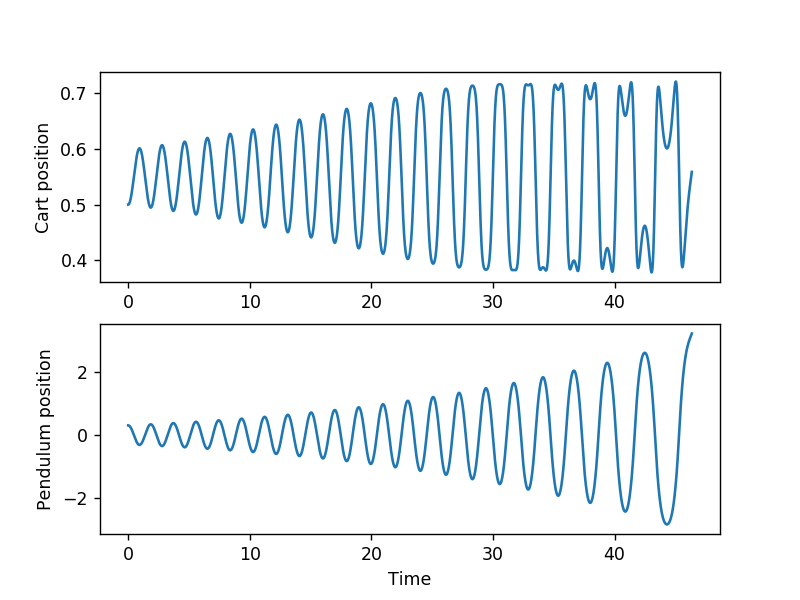

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAHu+21kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU4IHIyOTg0IDM3NTlmY2IgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE5IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NyBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAA/7ZYiE
ABD//veBvzLLXyK6yXH5530srM885DxyXYmuuNAAAAMAAAMAAAMABiMSN/6J4P4R4lcQE8kYWQT6
y3KCuinXVt83n9H0S0FxzClEFKxd1+TNS++zCta62/NP06dt9j0J6Dkf2rHaFv+dr20t1Bp3zX58
DBmkFpamrwUtoW26plf3qfo7kHaQyI08hEByMoaqItBilNRZ9xftAaNrfFzgbRx0zytlSZ7wyT/A
hWDCoOtQa0dEz95yhN3uVkH/sJoWqLvH6jo9pLsuTBPgi8kL8+yRBKPqVQ/YUDgwspb8Gnl6iUwZ
SurlWB0QXIgiBsb9xLD0CubzvixG8obluC6puxpOWyCYkAbatLU9jaC6EwsXEj+MlAWQBEJnFmon
oyTi8n0C0BKkW/r4xDr20Mgn+As9aPbE4158j/U2cEGxsD+LAx8n1ABol8bPKscdoc/NLOlg9pn4
16RMT+6SCUf+x7E0q2jztUa7lppa0uU7fP2cihnDlXP0SLhbPzcba+v6lTJont47ZpsCZxHf0yQC
KsNfufJ30ADdSnV2hwLCo9HvHLPbUaKXHDGoEHHo1WpVbro4AyhlKHS4R2POcQzDHQQpD01Egeg5
lEnIllRd2OJYfjP8tNQeyhkxZZ8vp9ng2KsnhBG2vCR+e8C6sinjAFN/BFpKmSmEo50v8xs0AE6N
/UE4OeRZBosW+0BvucH9m8bJ/lwr1tA7UQAUuwOto8aQoneNEU1oHnjFTQnvgNyjMNP0kpealaS5
m8cFk0UXO8jBucXBfOSpbLSxTfG82h1FTualEKTSftHmURQcNweaqaCK6IQJ7aDPKnIaIrGND/ly
e7C8cskfvJ+ONoDBweEoZr/wcIp95BBArj4BTJSzjfjhReDuvBRg+6EWdm9I6ACn7s8AAAMAWQ/m
vD4e3bXecjkIZZYAF2hqv//JTuZAF9PwckpYGn6w6Fso+2wY6j9O5s+t1GzNvKGRqoAoIOhbZgP1
2tDaX2MPWsmIAHyfDcM/iNl2XULTpb9YHxTrDg2obkT56c11jG8fbGEvCS4yxNdWPugT0AWOyy5V
N/5JhS+OU/EGQl8P2jtevHVb97tv3pwMEhPP+RXE1hDaXBqOAD3b1+nz5SAwbntsb9m3S2BFyQBm
obicAAADAAADAAaSANZSojYvK8Iy/DIXHsigkMI67tNY36QtJVsDO/YjaVDPnBOh18gonSGAWWZj
8uv81gMbB8uMvCHJ/7FjAQGMshOKW61G720msQbbfNS1phQsXI08lFCFy6Kb4QpMVBuLsRuPGs5x
+awdTqzx1WoCXwzCOy3SQ+46cdtKO/CJCXXnU1FCxlOVen21j5Qw33oBnemitfdTwr/+han/Xqe3
n3uVq/Xg9nVASZ73gFl0z5C8fvHdo4Pf/91Iq7xEDi54bLrg3YZPXkAW2ZVtYB/xQzygQByd9VZ5
bkpZiH5my3sFwiw0UwhWpWllZyMew1vRL0eLkNkgMQ7b8Mwsst9zzf/MVf8SYhpU5Q26T9nuehlo
Qf9T1JQK+sQvmf6KZXhoocHAK6M1KZNGx7TiWuDam7brgzEbdTaPONQPgdokdyNzoBOGqC8ZHv2s
CSz7WLOvxDJiHsCYmXTlThJXQ4AGt9BqSO86CrfYpJcHN/OGpr+WH1laPUJz2kH/9WwWSCJ5Ya8X
ge0N/MSAWzosaN72OQXm2f7dwxo8uJmH+wdeU1vZLRoIRJCtk5R631d5t8J0jRMrQPNUQLeavsuQ
fRKVhxZGbfw47CdxzXNL4Sdt86vrKdMyLQI0KPMhTEkqGAXaF2VpebCtjnwF4naYfodSaNXAsviO
BTEtiPGvu+bKm/XHpOqWtL21dR7MRADo/vY+vCU05lxQPdKKPOZ72nh8UGmUBL79ES/BvbHNnIIq
7q7ILXQQG9E0fdMOgZVi9xDjkqlyxvbLemUiBlSNxArIkdukVfSIQ3vKCHUTYuf9joTiGq8mLzWA
ZQNjptd9iyXSO+psp9YZugyrn35DJXYVRIPNW2lQaH7UR/e4LLl0YNYlM3StCVrmpA1M8U4fJxD9
f6yM1oILj7HYxSBFW+GgzSmK0UVqGQ4gPB6G3vY46gxPxFt84bK97LkXyVSxFN3/trRjVru2ti0i
gfVfeCDzXS3nXxZJScTTVwF9+9ODYZPJFrgQAthWY0AN4xhdWTvv4WrkySyrSmY4p1jAxdTT/rTa
picTbyUXOhyL/T82H/g3cM2JNNjAwxiJGOPnZ2leXHLVxFfyaCZErsaEqstq9S8eUkbXXUoIJN4a
eKKaRSgDyW02x76VThCFRtyWa0O8QVrV+3rzbpzXND8l8ALiUePbYhJQvwkAe+/DH17ILwf4DvQn
Z8DWPusFtQYuP7VWf6k+LYPEc72L1pe3iVQpvady1P8C5w+bVWg+b/nQaid0o95OAEffgDoT5wDM
xY9718tYUxh+1kOdFZPMQu1vTFntdKcxwmnJ1guYm+kbzV7dcvfaMz3bulImc8MWGS0UfQ3+3ACR
v/2ruPm4ZJrzvkNZNAovCSTarFeBsu2EsHs+CmeJIRVaPOCzVNf7JnLkq+l1yRrAXixxpFcwR+Uc
D2mheLQ9QwqEcmPB52mRVAPmWTBD4yk/PjaBGF5zQREtEtOCkRdWAnevGA2UYyHyh5JXjrh9lLc9
AVUOwsxeKRos7ydMTNauquVCrP3aFGTNaRfHEOFRasJtPkxhmu4vevaq4dh5yOmq2rXHfRCp7XqY
hjEpEwRoVGh5EwN6JNbL+SoD1TXTbd1n3iKM6cLewxz39zI5rmndur4LdkI+v16Dto8gLmY8YUMW
7zKR68x5eEU0s2kL3vKtuoplfOUFaKf6395VLlzNRXdYfiIb2mbu/yePPQmHEMdMcCVKmb224ZHT
9CPuhJOQRkhHiDZ76TeB0

In [14]:
# we call in the created cart pole
cart = CartPole()

# definig the dynamics of the system
A = np.array([[1, 0, cart.dt, 0],[0, 1, 0, cart.dt],[0, cart.dt*cart.mp*cart.g/cart.mc, 1, 0], [0, cart.dt*(cart.mp+cart.mc)*cart.g/(cart.l*cart.mc), 0, 1]])
B = np.array([[0],[0],[cart.dt/cart.mc],[cart.dt/(cart.l*cart.mc)]])

#define a desired resting position
z_d = np.array([0., np.pi, 0., 0.])

# definig the cost terms Q & R
Q = np.array([[0.8000,    0.8000,    0.8005,    0.8016],[0.8000,    0.8001,    0.8007,    0.8019],[0.8005,    0.8007,    0.8014,    0.8027],[0.8016,    0.8019,    0.8027,    0.8040]])*0.0000000001
R = np.eye(1)*1000

# Call in a function to solve the Ricatti Equations, so to get P and K
P, K = solve_ricatti_equations_inf(A,B,Q,R)
print("The Infinite Horizon Gain is")
print(K)

#defining the initial condition and the other desired conditions to simulate the cart with the control
z0 = np.array([0.5,0.3,0.,0.])

# A Horizon length is given inorder to simulate the system rather than for the working of the controller
horizon_length = 4635

# Simulating the cart with the control
z,u = cart.simulate(z0, LQ_error, horizon_length)

# Plotting the Cart position and the Pendulum Position in a graph

t = np.linspace(0,cart.dt*(horizon_length),horizon_length+1)
plt.figure()
plt.subplot(2,1,1)
plt.plot(t,z[0,:])
plt.ylabel('Cart position')
plt.subplot(2,1,2)
plt.plot(t,z[1,:])
plt.ylabel('Pendulum position')
plt.xlabel('Time')

animate_cart_pole(z, cart.dt)

To  make this system stable eventually, a small modfication has been made to the LQ controller to make the system stable. But this takes a long time to stabilize, so the simulation is observed for 50 seconds.

In [15]:
def LQ_error_mod(z,i):
    # z_d SHOULD BE DEFINED AS A GLOBAL VARIABLE for this function to work. Format => z_d = np.array([0, np.pi, 0, 0])
    if(np.allclose(z[1],z_d[1],0.3)):
        return K.dot(z-z_d)
    else: 
        return 0


The P value converges at iteration  553
The Infinite Horizon Gain is
[[   9.57752 -196.13646   16.44556  -59.44643]]


<IPython.core.display.Javascript object>


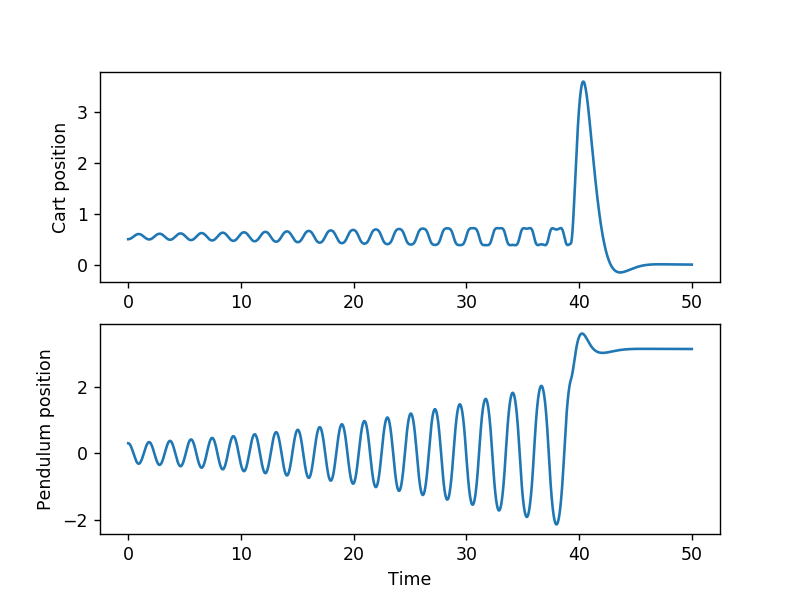

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAHqRW1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU4IHIyOTg0IDM3NTlmY2IgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE5IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NyBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAA/7ZYiE
ABD//veBvzLLXyK6yXH5530srM885DxyXYmuuNAAAAMAAAMAAAMABiMSN/6J4P4R4lcQE8kYWQT6
y3KCuinXVt83n9H0S0FxzClEFKxd1+TNS++zCta62/NP06dt9j0J6Dkf2rHaFv+dr20t1Bp3zX58
DBmkFpamrwUtoW26plf3qfo7kHaQyI08hEByMoaqItBilNRZ9xftAaNrfFzgbRx0zytlSZ7wyT/A
hWDCoOtQa0dEz95yhN3uVkH/sJoWqLvH6jo9pLsuTBPgi8kL8+yRBKPqVQ/YUDgwspb8Gnl6iUwZ
SurlWB0QXIgiBsb9xLD0CubzvixG8obluC6puxpOWyCYkAbatLU9jaC6EwsXEj+MlAWQBEJnFmon
oyTi8n0C0BKkW/r4xDr20Mgn+As9aPbE4158j/U2cEGxsD+LAx8n1ABol8bPKscdoc/NLOlg9pn4
16RMT+6SCUf+x7E0q2jztUa7lppa0uU7fP2cihnDlXP0SLhbPzcba+v6lTJont47ZpsCZxHf0yQC
KsNfufJ30ADdSnV2hwLCo9HvHLPbUaKXHDGoEHHo1WpVbro4AyhlKHS4R2POcQzDHQQpD01Egeg5
lEnIllRd2OJYfjP8tNQeyhkxZZ8vp9ng2KsnhBG2vCR+e8C6sinjAFN/BFpKmSmEo50v8xs0AE6N
/UE4OeRZBosW+0BvucH9m8bJ/lwr1tA7UQAUuwOto8aQoneNEU1oHnjFTQnvgNyjMNP0kpealaS5
m8cFk0UXO8jBucXBfOSpbLSxTfG82h1FTualEKTSftHmURQcNweaqaCK6IQJ7aDPKnIaIrGND/ly
e7C8cskfvJ+ONoDBweEoZr/wcIp95BBArj4BTJSzjfjhReDuvBRg+6EWdm9I6ACn7s8AAAMAWQ/m
vD4e3bXecjkIZZYAF2hqv//JTuZAF9PwckpYGn6w6Fso+2wY6j9O5s+t1GzNvKGRqoAoIOhbZgP1
2tDaX2MPWsmIAHyfDcM/iNl2XULTpb9YHxTrDg2obkT56c11jG8fbGEvCS4yxNdWPugT0AWOyy5V
N/5JhS+OU/EGQl8P2jtevHVb97tv3pwMEhPP+RXE1hDaXBqOAD3b1+nz5SAwbntsb9m3S2BFyQBm
obicAAADAAADAAaSANZSojYvK8Iy/DIXHsigkMI67tNY36QtJVsDO/YjaVDPnBOh18gonSGAWWZj
8uv81gMbB8uMvCHJ/7FjAQGMshOKW61G720msQbbfNS1phQsXI08lFCFy6Kb4QpMVBuLsRuPGs5x
+awdTqzx1WoCXwzCOy3SQ+46cdtKO/CJCXXnU1FCxlOVen21j5Qw33oBnemitfdTwr/+han/Xqe3
n3uVq/Xg9nVASZ73gFl0z5C8fvHdo4Pf/91Iq7xEDi54bLrg3YZPXkAW2ZVtYB/xQzygQByd9VZ5
bkpZiH5my3sFwiw0UwhWpWllZyMew1vRL0eLkNkgMQ7b8Mwsst9zzf/MVf8SYhpU5Q26T9nuehlo
Qf9T1JQK+sQvmf6KZXhoocHAK6M1KZNGx7TiWuDam7brgzEbdTaPONQPgdokdyNzoBOGqC8ZHv2s
CSz7WLOvxDJiHsCYmXTlThJXQ4AGt9BqSO86CrfYpJcHN/OGpr+WH1laPUJz2kH/9WwWSCJ5Ya8X
ge0N/MSAWzosaN72OQXm2f7dwxo8uJmH+wdeU1vZLRoIRJCtk5R631d5t8J0jRMrQPNUQLeavsuQ
fRKVhxZGbfw47CdxzXNL4Sdt86vrKdMyLQI0KPMhTEkqGAXaF2VpebCtjnwF4naYfodSaNXAsviO
BTEtiPGvu+bKm/XHpOqWtL21dR7MRADo/vY+vCU05lxQPdKKPOZ72nh8UGmUBL79ES/BvbHNnIIq
7q7ILXQQG9E0fdMOgZVi9xDjkqlyxvbLemUiBlSNxArIkdukVfSIQ3vKCHUTYuf9joTiGq8mLzWA
ZQNjptd9iyXSO+psp9YZugyrn35DJXYVRIPNW2lQaH7UR/e4LLl0YNYlM3StCVrmpA1M8U4fJxD9
f6yM1oILj7HYxSBFW+GgzSmK0UVqGQ4gPB6G3vY46gxPxFt84bK97LkXyVSxFN3/trRjVru2ti0i
gfVfeCDzXS3nXxZJScTTVwF9+9ODYZPJFrgQAthWY0AN4xhdWTvv4WrkySyrSmY4p1jAxdTT/rTa
picTbyUXOhyL/T82H/g3cM2JNNjAwxiJGOPnZ2leXHLVxFfyaCZErsaEqstq9S8eUkbXXUoIJN4a
eKKaRSgDyW02x76VThCFRtyWa0O8QVrV+3rzbpzXND8l8ALiUePbYhJQvwkAe+/DH17ILwf4DvQn
Z8DWPusFtQYuP7VWf6k+LYPEc72L1pe3iVQpvady1P8C5w+bVWg+b/nQaid0o95OAEffgDoT5wDM
xY9718tYUxh+1kOdFZPMQu1vTFntdKcxwmnJ1guYm+kbzV7dcvfaMz3bulImc8MWGS0UfQ3+3ACR
v/2ruPm4ZJrzvkNZNAovCSTarFeBsu2EsHs+CmeJIRVaPOCzVNf7JnLkq+l1yRrAXixxpFcwR+Uc
D2mheLQ9QwqEcmPB52mRVAPmWTBD4yk/PjaBGF5zQREtEtOCkRdWAnevGA2UYyHyh5JXjrh9lLc9
AVUOwsxeKRos7ydMTNauquVCrP3aFGTNaRfHEOFRasJtPkxhmu4vevaq4dh5yOmq2rXHfRCp7XqY
hjEpEwRoVGh5EwN6JNbL+SoD1TXTbd1n3iKM6cLewxz39zI5rmndur4LdkI+v16Dto8gLmY8YUMW
7zKR68x5eEU0s2kL3vKtuoplfOUFaKf6395VLlzNRXdYfiIb2mbu/yePPQmHEMdMcCVKmb224ZHT
9CPuhJOQRkhHiDZ76TeB0

In [16]:
# we call in the created cart pole
cart = CartPole()

# definig the dynamics of the system
A = np.array([[1, 0, cart.dt, 0],[0, 1, 0, cart.dt],[0, cart.dt*cart.mp*cart.g/cart.mc, 1, 0], [0, cart.dt*(cart.mp+cart.mc)*cart.g/(cart.l*cart.mc), 0, 1]])
B = np.array([[0],[0],[cart.dt/cart.mc],[cart.dt/(cart.l*cart.mc)]])

#define a desired resting position
z_d = np.array([0., np.pi, 0., 0.])  

# definig the cost terms Q & R
Q = np.array([[1000, 0, 0, 0],[0, 10, 0, 0],[0, 0, 10, 0],[0, 0, 0, 10]])*100
R = np.eye(1)*1000

# Call in a function to solve the Ricatti Equations, so to get P and K
P, K = solve_ricatti_equations_inf(A,B,Q,R)
print("The Infinite Horizon Gain is")
print(K)

#defining the initial condition and the other desired conditions to simulate the cart with the control
z0 = np.array([0.5,0.3,0.,0.])

# A Horizon length is given inorder to simulate the system rather than for the working of the controller
horizon_length = 5000

# Simulating the cart with the control
z,u = cart.simulate(z0, LQ_error_mod, horizon_length)

# Plotting the Cart position and the Pendulum Position in a graph

t = np.linspace(0,cart.dt*(horizon_length),horizon_length+1)
plt.figure()
plt.subplot(2,1,1)
plt.plot(t,z[0,:])
plt.ylabel('Cart position')
plt.subplot(2,1,2)
plt.plot(t,z[1,:])
plt.ylabel('Pendulum position')
plt.xlabel('Time')

animate_cart_pole(z, cart.dt)

This controller now stabilizes the system at around 46 seconds of runtime.

For this controller to work, the system needs to have no initial velocity or acceleration, since the initial control input is zero until the system gets close to the resting position, and this may not be achievable with a non-zero velocity and acceleration. The initial position of $\theta$ cannot be $0$ aswell, because the system is stable at $\theta = 0$, and therefore no momentum to get the system to to behave as shown earlier. 
A more robust LQR controller will be needed to make the system move from a stable state at $\theta = 0$ to the desired $\theta = \pi$. And that should be able to even perform under a non-zero initial velocity and acceleration.